<h><font size = "4"><center><b>Astrofísica Computacional</b></center></font></h>
<h><center>Ejercicios 06. Volúmenes Finitos. Advección multi-dimensional</center></h>

**A. Solución de la ecuación de advección lineal 1D.**

La ecuación de advección lineal en una dimensión es
\begin{equation}
    \frac{\partial \psi}{\partial t} + v \frac{\partial \psi}{\partial x} = 0\,,
\end{equation}
donde la velocidad de advección , $v$, es una constante.

1. Implemente un código que resuelva numéricamente esta ecuación utilizando el método de volúmenes finitos. Considere como condición inicial un perfil gaussiano,
\begin{equation}
    \Psi_0 = \psi(x, t=0) = e^{-\frac{(x - x_0)^2}{2\sigma^2}}\,,
\end{equation}
con $x_0 = 30$, $\sigma = \sqrt{15}$ y un perfil sinusoidal
\begin{equation}
    \Psi_0 = \psi(x, t=0) = \sin{\left(\frac{4\pi x}{L}\right)}
\end{equation}
con $L=100$. En los dos casos, considere una velocidad de advección constante positiva $v=0.2$ y resuelva en el dominio espacial $x \in \left[0,100\right]$ para un intervalo temporal con $t \in [0,1000]$. Implemente condiciones de frontera periódicas en los dos casos.

**B. Advección Multidimensional**

La ecuación de avección lineal 2-dimensional es
\begin{equation}
    \partial_t\pi + v^x \partial_x\psi + v^y \partial_y\psi = 0\,,
\end{equation}
donde $v^x$ y $v^y$ son las componentes de la velocidad en las direcciones $x$ y $y$, respectivamente.

1. Resuelva numéricamente la ecuación de advección 2-dimensional mediante el método de volúmenes finitos considerando un perfil inicial Gaussiano,
\begin{equation}
    \Psi_0 = \psi(t=0, x, y) = e^{-\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2}}
\end{equation}
donde $x_0 = 20$, $y_0 = 30$, $\sigma = \sqrt{20}$ y considerando $v^x = 0.8$, $v^y = 1.0$ en el dominio espacial $x \in [0, 100]$ y $y \in [0,100]$. Además implemente la posibilidad de condiciones de frontera de gradiente nulo (outflow) y periódicas.

---
## **Desarrollo**

**A.1.** Primero que todo cargamos las librerías que se van a utilizar

In [2]:
using Plots
using Printf

Posteriormente escribimos la función que dará el perfil inicial gaussiano del comportamiento que estamos describiendo, junto con los intervalos y pasos de tiempo y posición en los que vamos a analizar el comportamiento de nuestro método numérico.

In [17]:
function Gaussian_profile(x)
    x0 = 30
    sigma = sqrt(15)
    prof = exp(-(x-x0)^2/(2*sigma^2))
    return prof
end

#spacial grid
x_i = 0
x_f = 100
Nx = 1000
x = LinRange(x_i, x_f, Nx)

#Advection velocity
v = -0.2

#Criterio CFL
CFL = 0.1
dx = x[2] - x[1]
dt = CFL*dx/abs(v)

#time grid
t_i = 0
t_f = 1000
Nt = round(Int64, (t_f - t_i)/dt)
t = LinRange(t_i, t_f, Nt)

19980-element LinRange{Float64}:
 0.0,0.0500526,0.100105,0.150158,0.20021,…,999.8,999.85,999.9,999.95,1000.0

Así, establecido nuestro dominio espacial y temporal junto con el grid respectivo de cada uno de ellos, implementamos la función de integración de la ecuación diferencial de advección por el método de volúmenes finitos.

In [19]:
#flux function
flux(psi::Float64,v::Float64) = v*psi

function Finite_Volume_try1(Psi0, F, t, x, v, dt, dx, boundary = "outflow")
    nx = length(x)
    nt = length(t)
    psi = zeros(nt, nx)
    psi[1,1:length(x)] = Psi0.(x)
    nu = (v*dt)/dx
    psi_half = zeros(nx-1)
    for n in 1:length(t)-1
        #Riemman's problem
        if v>0
            for j in 2:nx-1
                psi_half[j] = psi[n,j] + (dx)*0.5*(1+nu)*(psi[n,j+1] - psi[n,j-1])/(2*dx)
            end
            #Boundary conditions v>0
            if boundary=="outflow" # Outflow boundary conditions
                psi_half[1] = psi[n,2] + (dx)*0.5*(1+nu)*(psi[n,2+1] - 0.)/(2*dx)
            else # Periodic boundary conditions
                psi_half[1] = psi[n,2] + (dx)*0.5*(1+nu)*(psi[n,2+1] - psi[n,nx])/(2*dx)
            end
        else
            for j in nx-2:-1:1
                psi_half[j] = psi[n,j+1] - (dx)*0.5*(1+nu)*(psi[n,j+2] + psi[n,j])/(2*dx)
            end
                #Boundary conditions
            if boundary=="outflow" # Outflow boundary conditions
                psi_half[nx-1] = psi[n,nx] - (dx)*0.5*(1+nu)*(0. + psi[n,nx-1])/(2*dx)
            else # Periodic boundary conditions
                psi_half[nx] = psi[n,nx] - (dx)*0.5*(1+nu)*(psi[n,1] + psi[n,nx-1])/(2*dx)
            end
        end
            
        #Next step
        for j in 2:nx-1
            #First half - it depends on the boundary conditions
            psi[n+1,j] = psi[n,j] - (dt/dx)*(F(psi_half[j],v) - F(psi_half[j-1],v))
        end
            
        #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
            psi[n+1,1] = psi[n+1,2]
            psi[n+1,nx] = psi[n+1,nx-1]
        else # Periodic boudnary conditions
            if v>0
                psi[n+1,1] = psi[n+1,nx-1]
                psi[n+1,nx] = psi[n+1,nx-1]
            else
                psi[n+1,1] = psi[n+1,2]
                psi[n+1,nx] = psi[n+1,1]
            end
        end
    end
    return psi
end

psi_fv = Finite_Volume_try1(Gaussian_profile, flux, t, x, v, dt, dx, "periodical")

@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv[i,:], ylim = (0,1))
end
gif(anim, "Finite_Volume_gaussian.gif", fps = 15)

LoadError: [91mBoundsError: attempt to access 999-element Array{Float64,1} at index [1000][39m

dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_gaussian.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_gaussian.gif")
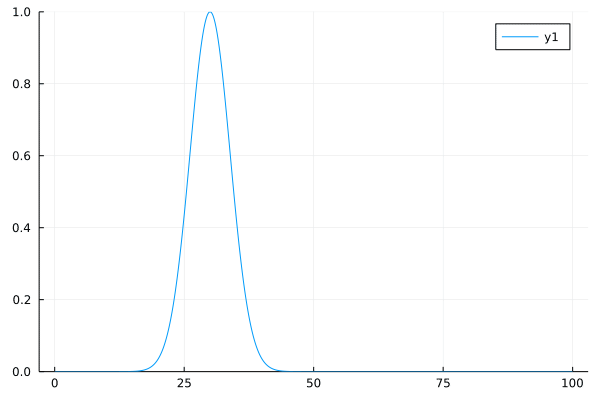

In [15]:
#flux function
flux(psi::Float64,v::Float64) = v*psi

function Finite_Volume(Psi0, F, t, x, v, dt, dx, boundary = "outflow")
    nx = length(x)
    nt = length(t)
    psi = zeros(nt, nx)
    psi[1,1:length(x)] = Psi0.(x)
    nu = (v*dt)/dx
    psi_half = zeros(nx)
    for n in 1:length(t)-1
        #Riemman's problem
        if v>0
            psi_half[1] = psi[n,1]
            psi_half[nx] = psi[n,nx]
            for j in 2:nx-1
                psi_half[j] = psi[n,j] + (dx)*0.5*(1+nu)*(psi[n,j+1] - psi[n,j-1])/(2*dx)
            end
        else
            psi_half[1] = psi[n,1]
            psi_half[nx] = psi[n,2]
            psi_half[nx-1] = psi[n,1]
            for j in nx-2:-1:2
                psi_half[j] = psi[n,j+1] - (dx)*0.5*(1+nu)*(psi[n,j+2] + psi[n,j])/(2*dx)
            end
        end
            
        #Next step
        for j in 2:nx-1
            #First half - it depends on the boundary conditions
            psi[n+1,j] = psi[n,j] - (dt/dx)*(F(psi_half[j],v) - F(psi_half[j-1],v))
        end
            
        #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
            psi[n+1,1] = psi[n+1,2]
            psi[n+1,nx] = psi[n+1,nx-1]
        else # Periodic boudnary conditions
            if v>0
                psi[n+1,1] = psi[n+1,nx-1]
                psi[n+1,nx] = psi[n+1,nx-1]
            else
                psi[n+1,1] = psi[n+1,2]
                psi[n+1,nx] = psi[n+1,1]
            end
        end
    end
    return psi
end

psi_fv = Finite_Volume(Gaussian_profile, flux, t, x, v, dt, dx, "periodical")

@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv[i,:], ylim = (0,1))
end
gif(anim, "Finite_Volume_gaussian.gif", fps = 15)

Ahora utilizamos la misma función de integración pero ahora estableciendo un perfil sinusoidal

dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_sine.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_sine.gif")
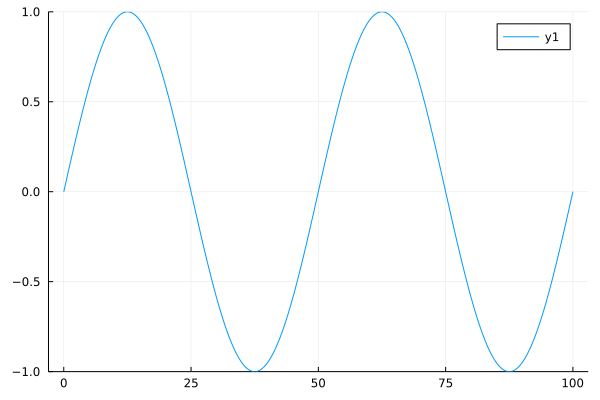

In [11]:
function sin_profile(x)
    L = 100
    prof = sin(4*pi*x/L)
    return prof
end

psi_fv2 = Finite_Volume_try1(sin_profile, flux, t, x, v, dt, dx, "outflow")

@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv2[i,:], ylim = (-1,1))
end

gif(anim, "Finite_Volume_sine.gif", fps = 15)

**B.1**

Establecemos la función de perfil inicial gaussiano en dos dimensiones y el dominio de integración.

In [3]:
function gaussian_profile_2D(x, y)
    x0 = 20
    y0 = 30
    sigma = sqrt(20)
    prof = exp(-((x-x0)^2 + (y-y0)^2)/(2*sigma^2))
    return prof
end

xi = 0
xf = 100
Nx = 100
x = LinRange(xi, xf, Nx)
dx = x[2] - x[1]

yi = 0
yf = 100
Ny = 100
y = LinRange(yi, yf, Ny)
dy = y[2] - y[1]

#Advection velocity
vx = 0.8
vy = 1.0
v_2D = sqrt(vx^2+vy^2)
dr = sqrt(dx^2 + dy^2)

#Criterio CFL
CFL = 0.1
dt = CFL*dr/abs(v_2D)

#time grid
t_i = 0
t_f = 1000
Nt = round(Int64, (t_f - t_i)/dt)
t = LinRange(t_i, t_f, Nt)

8965-element LinRange{Float64}:
 0.0,0.111557,0.223115,0.334672,0.446229,…,999.665,999.777,999.888,1000.0

- Problema de Riemman para la coordenada $x$ - tener en cuenta solo si vy<0 o vy>0 - hay que hacerlo para cada punto del dominio total
\begin{equation}
\psi_{i+\frac{1}{2},j}^{n+\frac{1}{2}} = \mathcal{R}{\left(\psi_{i+\frac{1}{2},j, L}^{n+\frac{1}{2}}, \psi_{i+\frac{1}{2},j, R}^{n+\frac{1}{2}}\right)}
\end{equation}

- Calcular el $\bar{\psi}_{i,j}$
\begin{equation}
\bar{\psi}_{i,j} = \psi_{i,j}^n 
  - \Delta t \frac{ u \psi_{i+\frac{1}{2},j}^{n+\frac{1}{2}} - u \psi_{i-\frac{1}{2},j}^{n+\frac{1}{2}} }{\Delta x}\\
\end{equation}

- Calcular el problema de Riemann para la coordenada $y$ con los valores de $\bar{\psi}_{i,j}$
\begin{equation}
\bar{\psi}_{i+\frac{1}{2},j}^{n+\frac{1}{2}} = \mathcal{R}{\left(\bar{\psi}_{i+\frac{1}{2},j, L}^{n+\frac{1}{2}}, \bar{\psi}_{i+\frac{1}{2},j, R}^{n+\frac{1}{2}}\right)}
\end{equation}

- Calcular el siguiente paso de tiempo 
\begin{equation}
\psi_{i,j}^{n+1} = \bar{\psi}_{i,j}
  - \Delta t \frac{ v \bar{\psi}_{i,j+\frac{1}{2}}^{n+\frac{1}{2}} - v \bar{\psi}_{i,j-\frac{1}{2}}^{n+\frac{1}{2}} }{\Delta y}.
\end{equation}

In [24]:
#flux function
flux(psi::Float64,v::Float64) = v*psi

function FV2D(Psi0, F, t, x, y, vx, vy, dt, dx, boundary = "outflow")
    nx = length(x)
    ny = length(y)
    nt = length(t)
    psi = zeros(nt, nx, ny)
    for i in 1:nx
        psi[1,i,:] = Psi0.(x[i],y)
    end
    nux = (vx*dt)/dx
    nuy = (vy*dt)/dx
    psi_half_x = zeros(nx,ny)
    psi_half_y = zeros(nx,ny)
    for n in 1:nt-1
        #coordinate x Riemman's problem
        if vx>0
            psi_half_x[1,:] .= psi[n,1,:]
            psi_half_x[nx,:] .= psi[n,nx,:]
            for i in 2:nx-1
                psi_half_x[i,:] .= psi[n,i,:] .+ dx*0.5*(1-nux)*(psi[n,i+1,:] .- psi[n,i-1,:])/(2*dx)
            end
        else
            psi_half[1,:] .= psi[n,1,:]
            psi_half[nx,:] .= psi[n,2,:]
            psi_half[nx-1,:] .= psi[n,1,:]
            for i in nx-2:-1:1
                psi_half_x[i,:] .= psi[n,i,:] .- dx*0.5*(1+nux)*(psi[n,i+2,:] .- psi[n,i,:])/(2*dx)
            end
        end
        #coordinate y Riemman's problem
        for j in 2:ny-1
            if vy>0
                psi_half_y[:,1] .= psi[n,:,1]
                psi_half_y[:,ny] .= psi[n,:,ny]
                for i in 2:ny-1
                    psi_half_y[:,j] .= psi[n,:,j] .+ dy*0.5*(1-nuy)*(psi[n,:,j+1] .- psi[n,:,j-1])/(2*dy)
                end
            else
                psi_half_y[:,1] .= psi[n,:,1]
                psi_half_y[:,ny] .= psi[n,:,2]
                psi_half_y[:,ny-1] .= psi[n,:,1]
                for i in ny-2:-1:1
                    psi_half_y[:,j] .= psi[n,:,j] .- dy*0.5*(1+nuy)*(psi[n,:,j+2] .- psi[n,:,j])/(2*dy)
                end
            end
        end
        #next time step
        for i in 2:nx-1
            for j in 2:ny-1
                psi[n+1,i,j] = psi[n,i,j] - dt*((F(psi_half_x[i,j], vx) - F.(psi_half_x[i-1,j], vx))/dx + (F.(psi_half_y[i,j], vy) - F.(psi_half_y[i,j-1], vy))/dy)
            end
        end
        #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
            psi[n+1,1,:] .= psi[n+1,2,:]
            psi[n+1,nx,:] .= psi[n+1,nx-1,:]
            psi[n+1,:,1] .= psi[n+1,:,2]
            psi[n+1,:,ny] .= psi[n+1,:,ny-1]
        else # Periodic boudnary conditions
            if vx>0
                psi[n+1,1,:] .= psi[n+1,nx-1,:]
                psi[n+1,nx,:] .= psi[n+1,nx-1,:]
            else
                psi[n+1,1,:] .= psi[n+1,2,:]
                psi[n+1,nx,:] .= psi[n+1,1,:]
            end
            if vy>0
                psi[n+1,:,1] = psi[n+1,:,ny-1]
                psi[n+1,:,ny] = psi[n+1,:,ny-1]
            else
                psi[n+1,:,1] = psi[n+1,:,2]
                psi[n+1,:,ny] = psi[n+1,:,1]
            end
        end
    end
    return psi
end
psi_fv2D = FV2D(gaussian_profile_2D, flux, t, x, y, vx, vy, dt, dx, "outflow")


8965×100×100 Array{Float64,3}:
[:, :, 1] =
 7.6812e-15   2.05605e-14  5.22975e-14  …   3.05425e-78   5.51134e-80
 6.54292e-14  6.54292e-14  1.71493e-13     -6.31313e-76  -6.31313e-76
 5.78445e-14  5.78445e-14  1.4292e-13       2.31003e-74   2.31003e-74
 5.18545e-14  5.18545e-14  1.20732e-13     -6.57625e-73  -6.57625e-73
 4.71163e-14  4.71163e-14  1.03391e-13      1.43717e-71   1.43717e-71
 4.33636e-14  4.33636e-14  8.97395e-14  …  -2.36322e-70  -2.36322e-70
 4.03894e-14  4.03894e-14  7.89013e-14      2.83451e-69   2.83451e-69
 3.80323e-14  3.80323e-14  7.02196e-14     -2.34998e-68  -2.34998e-68
 3.61659e-14  3.61659e-14  6.32006e-14      1.20132e-67   1.20132e-67
 3.46911e-14  3.46911e-14  5.74738e-14     -2.53865e-67  -2.53865e-67
 3.35295e-14  3.35295e-14  5.27609e-14  …  -6.08767e-67  -6.08767e-67
 3.26191e-14  3.26191e-14  4.88523e-14      2.89665e-66   2.89665e-66
 3.19105e-14  3.19105e-14  4.55893e-14      6.95631e-66   6.95631e-66
 ⋮                                      ⋱      

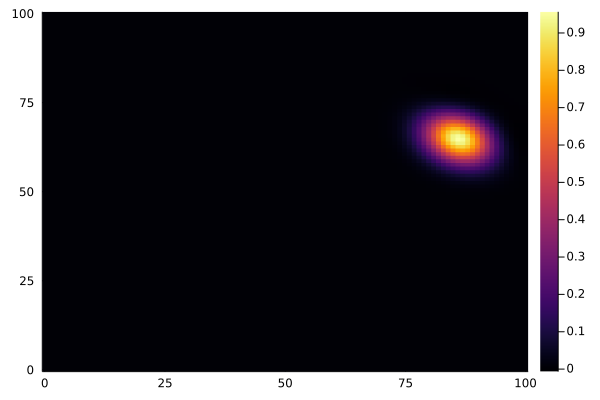

In [35]:
heatmap(x, y, psi_fv2D[500,:,:])

(8965, 100, 100)dt = 0.1115469960 
dx = 1.0101010101

GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_2D.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_2D.gif")
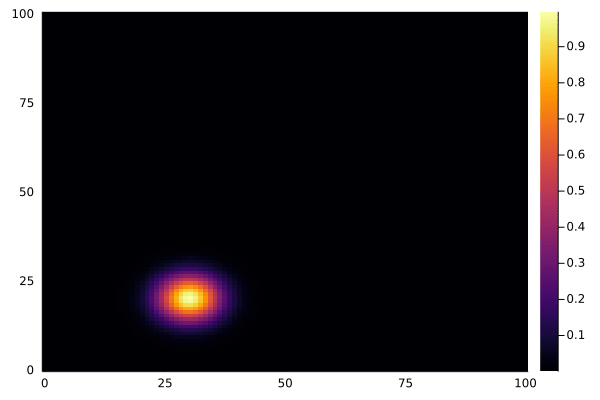

In [40]:
print(size(psi_fv2D))
@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:2000 
    heatmap(x,y,psi_fv2D[i,:,:])
end
gif(anim, "Finite_Volume_2D.gif", fps = 15)
# heatmap(x, y, psi_fv2D[100,:,:])